In [2]:
!pip3 install langchain langchain-openai python-dotenv requests image

### Imports and Load Env

In [3]:
import dotenv
import json
import requests
import os
import openai
from datetime import datetime
from langchain.chains import APIChain
from langchain.chains.api import open_meteo_docs
from langchain_openai import OpenAI

dotenv.load_dotenv()

True

### Define the Request Message

In [4]:
requestMessage = "What is the current weather for the congo? Provide temperature in degrees Fahrenheit."

### Get the Weather Information

In [5]:
llm = OpenAI(temperature=0)
chain = APIChain.from_llm_and_api_docs(
    llm,
    open_meteo_docs.OPEN_METEO_DOCS,
    verbose=True,
    limit_to_domains=["https://api.open-meteo.com/"],
)
weatherResponse = chain.run(requestMessage)

print(weatherResponse)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new APIChain chain...
 https://api.open-meteo.com/v1/forecast?latitude=-4.0383&longitude=21.7587&current_weather=true&temperature_unit=fahrenheit
{"latitude":-4.0,"longitude":21.75,"generationtime_ms":0.05793571472167969,"utc_offset_seconds":0,"timezone":"GMT","timezone_abbreviation":"GMT","elevation":420.0,"current_weather_units":{"time":"iso8601","interval":"seconds","temperature":"°F","windspeed":"km/h","winddirection":"°","is_day":"","weathercode":"wmo code"},"current_weather":{"time":"2024-02-14T07:00","interval":900,"temperature":76.6,"windspeed":4.7,"winddirection":238,"is_day":1,"weathercode":2}}

> Finished chain.
 The current weather for the Congo is 76.6 degrees Fahrenheit with a wind speed of 4.7 km/h and a wind direction of 238 degrees. The weather code is 2, indicating a specific weather condition. 


### Summarize the Response to JSON and Get Insights

In [6]:
response = openai.chat.completions.create(
  model="gpt-4",
  messages=[
    {
      "role": "system",
      "content": """You are to summarize the provided message and respond with JSON. Gather information from the message as well as insights.
      Extract key information like the geographic region, current temperature, and summarize the current weather into a general category.
      Provide insight into one thing that the geographic region is known for.
      The current date and time in CST is """ + datetime.now().isoformat() + """. Provide insight into current date and time in the region in the message.
      Here is an example response: {\"region\": \"city, State\", \"currentTemperature\": \"45 degrees F\", \"weatherCategory\": \"cloudy\", \"regionalFame\": \"parthenon\", \"currentTimeInRegion\": \"10:45pm\", \"currentDayInRegion\": \"Wednesday\"}.
      """
    },
    {
      "role": "user",
      "content": weatherResponse
    }
  ],
  temperature=.5,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

weatherSummaryJson = json.loads(response.choices[0].message.content)
print(weatherSummaryJson)

{'region': 'Congo', 'currentTemperature': '76.6 degrees F', 'weatherCategory': 'specific weather condition', 'regionalFame': 'rainforests', 'currentTimeInRegion': '07:06am', 'currentDayInRegion': 'Thursday'}


### Generate an Image Based on the Summarized Data

Abstract visual of a cat in the foreground with a background of Congo. Prominently displaying rainforests. The time of day is 07:06am. Represent the weather as specific weather condition.


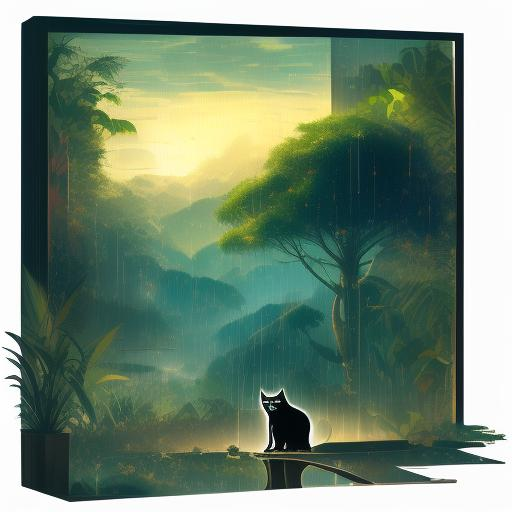

In [7]:

def buildQuery():
	region = weatherSummaryJson["region"]
	temp = weatherSummaryJson["currentTemperature"]
	wxCategory = weatherSummaryJson["weatherCategory"]
	fame = weatherSummaryJson["regionalFame"]
	currTime = weatherSummaryJson["currentTimeInRegion"]

	return f"Abstract visual of a cat in the foreground with a background of {region}. Prominently displaying {fame}. The time of day is {currTime}. Represent the weather as {wxCategory}."

imgReqMsg = buildQuery()
print(imgReqMsg)

huggingfaceApiKey = os.getenv("HUGGINGFACE_API_KEY")
# print(huggingfaceApiKey)

API_URL = "https://api-inference.huggingface.co/models/openskyml/midjourney-v4-xl"
headers = {"Authorization": f"Bearer {huggingfaceApiKey}"}
response = requests.post(API_URL, headers=headers, json={"inputs": imgReqMsg})

imageBytes = response.content

# You can access the image with PIL.Image for example
import io
from PIL import Image
Image.open(io.BytesIO(imageBytes))